# Configuration

In [1]:
n_events_generated = int(1e5)
data_path          = "/Users/Gonzalo/github/NEXTdata/MC/ECEC/v2_center/kdst/output/data"
corr_filename      = "corrections_MC.h5"
corr_group         = "XYcorrections"
corr_node          = "GeometryE_5.0mm"

figure_size        = 12,  8
figure_size_1_row  = 12,  5
figure_size_3_rows = 12, 15
font_size          = 15

# Imports

In [2]:
import os
import glob

import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import matplotlib.colors as clr

from invisible_cities.core .fit_functions import profileXY
from invisible_cities.core .fit_functions import fit
from invisible_cities.core .fit_functions import expo
from invisible_cities.reco .dst_functions import load_xy_corrections
from invisible_cities.icaro.hst_functions import display_matrix

# Set style

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

# Load data and corrections

In [4]:
filenames = glob.glob(os.path.join(data_path, "*"))
dfs       = [pd.DataFrame.from_records(tb.open_file(filename).root.DST.Events.read())
             for filename in filenames]
df        = pd.concat(dfs)

In [5]:
xycorr    = load_xy_corrections(corr_filename,
                                group         = corr_group,
                                node          = corr_node,
                                norm_strategy = "index",
                                norm_opts     = {"index": (40, 40)})

# Data globals

In [6]:
pes_to_keV    = 63.63 / 2e4
n_events_kdst = np.unique(df.event).size
first         = ~df.event.duplicated()

# Correct geometry

In [7]:
df["Ecorr"] = df.S2e * xycorr(df.X, df.Y).value * pes_to_keV

# Functions

In [8]:
def norm_hist(data, bins, histtype="step", lw=3, color="k", **kwargs):
    weights = np.full(data.size, 100/data.size)
    return plt.hist(data, bins, weights=weights, histtype=histtype, lw=lw, color=color, **kwargs)

def norm_hist2d(xdata, ydata, bins, **kwargs):
    weights = np.full(xdata.size, 100/data.size)
    return plt.hist2d(xdata, ydata, bins, weights=weights, cmin=1e-20, **kwargs)

def norm_hist_and_fraction(*args, xoffset = 0.1, yoffset = 0.8, **kwargs):
    hist  = norm_hist(*args, **kwargs)
    ysum  = np.sum(hist[0])
    xtext = plt.xlim()[0] + np.diff(plt.xlim()) * xoffset
    ytext = plt.ylim()[0] + np.diff(plt.ylim()) * yoffset
    text  = plt.text(xtext, ytext, f"{ysum:.1f} %")
    return hist, text

# Efficiency

In [9]:
print(f"Total number of events generated: {n_events_generated:>8} = {100 * n_events_generated / n_events_generated:>6.2f} %")
print(f"Total number of events in kDST  : {n_events_kdst:>8} = {100 * n_events_kdst / n_events_generated:>6.2f} %")

Total number of events generated:   100000 = 100.00 %
Total number of events in kDST  :    96881 =  96.88 %


# S1/S2 counts

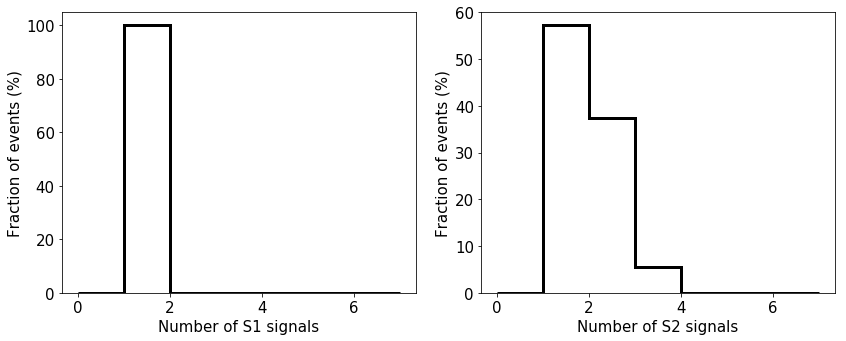

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
norm_hist(df.nS1[first], np.arange(0, 8))
plt.xlabel("Number of S1 signals")
plt.ylabel("Fraction of events (%)")

plt.subplot(1, 2, 2)
norm_hist(df.nS2[first], np.arange(0, 8))
plt.xlabel("Number of S2 signals")
plt.ylabel("Fraction of events (%)")
plt.tight_layout()

# Spatial distributions

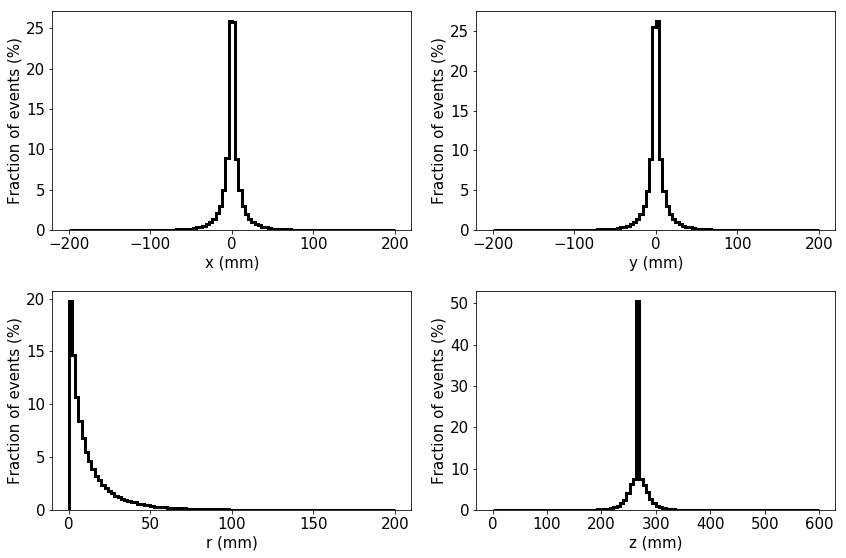

In [11]:
plt.subplot(2, 2, 1)
norm_hist(df.X, np.linspace(-200, 200, 101))
plt.xlabel("x (mm)")
plt.ylabel("Fraction of events (%)")

plt.subplot(2, 2, 2)
norm_hist(df.Y, np.linspace(-200, 200, 101))
plt.xlabel("y (mm)")
plt.ylabel("Fraction of events (%)")

plt.subplot(2, 2, 3)
norm_hist(df.R, np.linspace(0, 200, 101))
plt.xlabel("r (mm)")
plt.ylabel("Fraction of events (%)")

plt.subplot(2, 2, 4)
norm_hist(df.Z, np.linspace(0, 600, 101))
plt.xlabel("z (mm)")
plt.ylabel("Fraction of events (%)")

plt.tight_layout()

# S1/S2 counts spatial dependence

Text(0, 0.5, 'Fraction of events (%)')

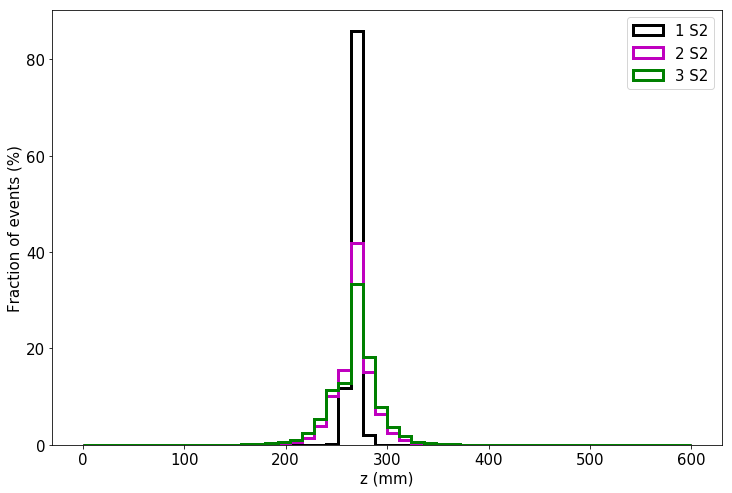

In [12]:
norm_hist(df.Z[df.nS2 == 1], np.linspace(0, 600, 51), color="k", label="1 S2")
norm_hist(df.Z[df.nS2 == 2], np.linspace(0, 600, 51), color="m", label="2 S2")
norm_hist(df.Z[df.nS2 == 3], np.linspace(0, 600, 51), color="g", label="3 S2")
plt.legend()
plt.xlabel("z (mm)")
plt.ylabel("Fraction of events (%)")

Text(0, 0.5, 'Fraction of events (%)')

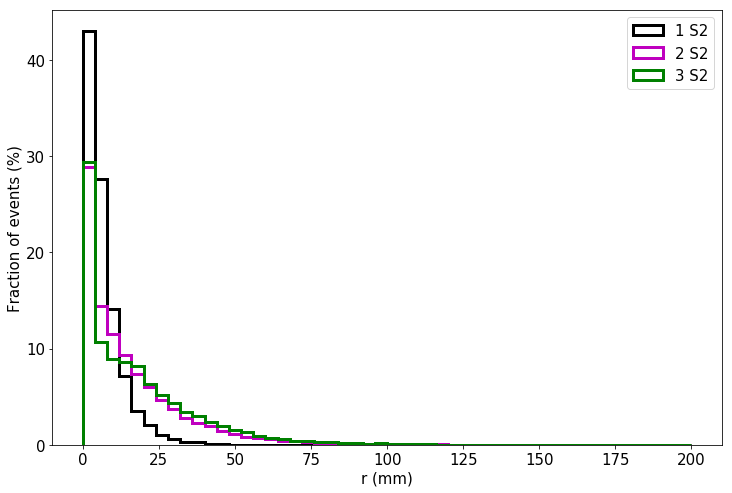

In [13]:
norm_hist(df.R[df.nS2 == 1], np.linspace(0, 200, 51), color="k", label="1 S2")
norm_hist(df.R[df.nS2 == 2], np.linspace(0, 200, 51), color="m", label="2 S2")
norm_hist(df.R[df.nS2 == 3], np.linspace(0, 200, 51), color="g", label="3 S2")
plt.legend()
plt.xlabel("r (mm)")
plt.ylabel("Fraction of events (%)")

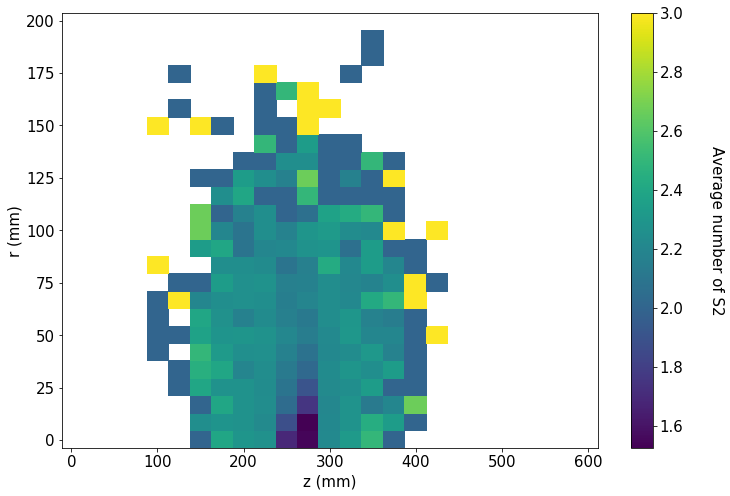

In [14]:
z, r, n, _ = profileXY(df.Z, df.R, df.nS2, 25, 25, xrange=(0, 600), yrange=(0, 200))

*_, cb = display_matrix(z, r, n, cmin=1e-20)
plt.xlabel("z (mm)")
plt.ylabel("r (mm)")
cb.set_label("Average number of S2", rotation=-90, labelpad=40)

Text(0, 0.5, '# events')

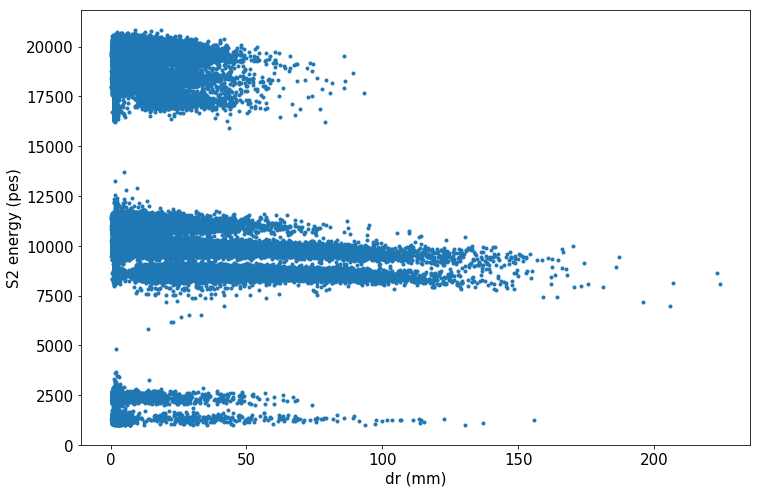

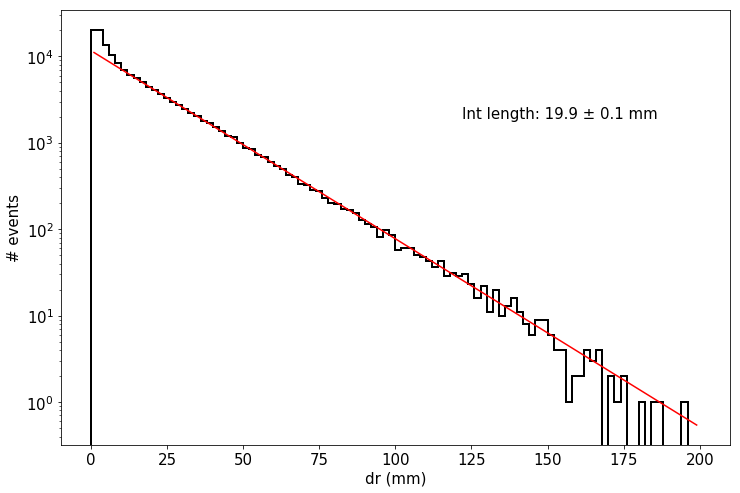

In [15]:
subdf = df[df.nS1 == 1]

dr = np.sqrt((subdf.Z.values - 532/2)**2 + subdf.R.values**2)

plt.figure()
plt.scatter(dr, subdf.S2e, marker=".")

plt.xlabel("dr (mm)")
plt.ylabel("S2 energy (pes)")

plt.figure()
bins = np.linspace(0, 200, 101)
y, x = np.histogram(dr, bins)
x    = x[:-1] + np.diff(x) / 2
f    = fit(expo, x, y, (1e4, -1e2), fit_range=(25, 125))

plt.hist(dr, bins, histtype="step", color="k", lw=2)
plt.plot(x, f.fn(x), "r-")
plt.text(.6, .75, f"Int length: {-f.values[1]:.1f} ± {f.errors[1]:.1f} mm", transform=plt.gca().transAxes)

plt.yscale("log")
plt.xlabel("dr (mm)")
plt.ylabel("# events")


# S2/evt properties

Text(0, 0.5, 'Fraction of events (%)')

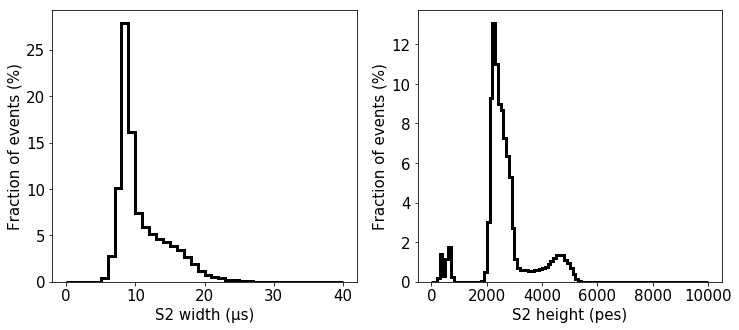

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
norm_hist(df.S2w, np.linspace(0, 40, 41))
plt.xlabel("S2 width (µs)")
plt.ylabel("Fraction of events (%)")

plt.subplot(1, 2, 2)
norm_hist(df.S2h, np.linspace(0, 1e4, 101))
plt.xlabel("S2 height (pes)")
plt.ylabel("Fraction of events (%)")

Text(0, 0.5, 'Fraction of events (%)')

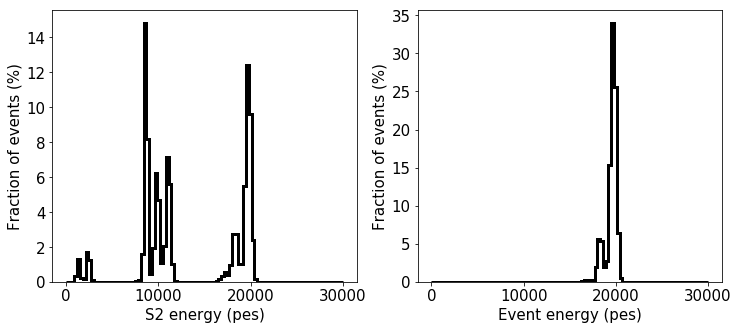

In [17]:
plt.figure(figsize=(12, 5))
evt_energy = df.groupby("event").S2e.sum()

plt.subplot(1, 2, 1)
norm_hist(df.S2e, np.linspace(0, 3e4, 101))
plt.xlabel("S2 energy (pes)")
plt.ylabel("Fraction of events (%)")

plt.subplot(1, 2, 2)
norm_hist(evt_energy, np.linspace(0, 3e4, 101))
plt.xlabel("Event energy (pes)")
plt.ylabel("Fraction of events (%)")

Text(0, 0.5, 'Fraction of events (%)')

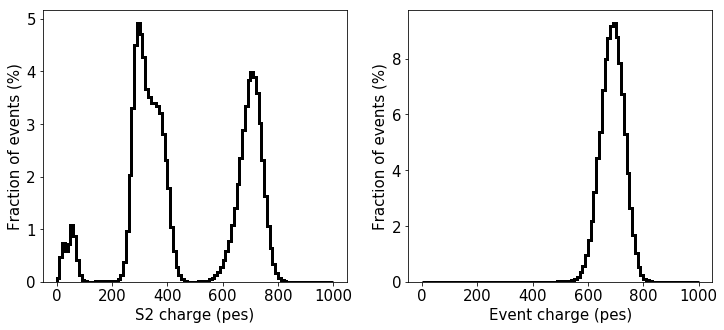

In [18]:
plt.figure(figsize=(12, 5))
evt_charge = df.groupby("event").S2q.sum()

plt.subplot(1, 2, 1)
norm_hist(df.S2q, np.linspace(0, 1e3, 101))
plt.xlabel("S2 charge (pes)")
plt.ylabel("Fraction of events (%)")

plt.subplot(1, 2, 2)
norm_hist(evt_charge, np.linspace(0, 1e3, 101))
plt.xlabel("Event charge (pes)")
plt.ylabel("Fraction of events (%)")

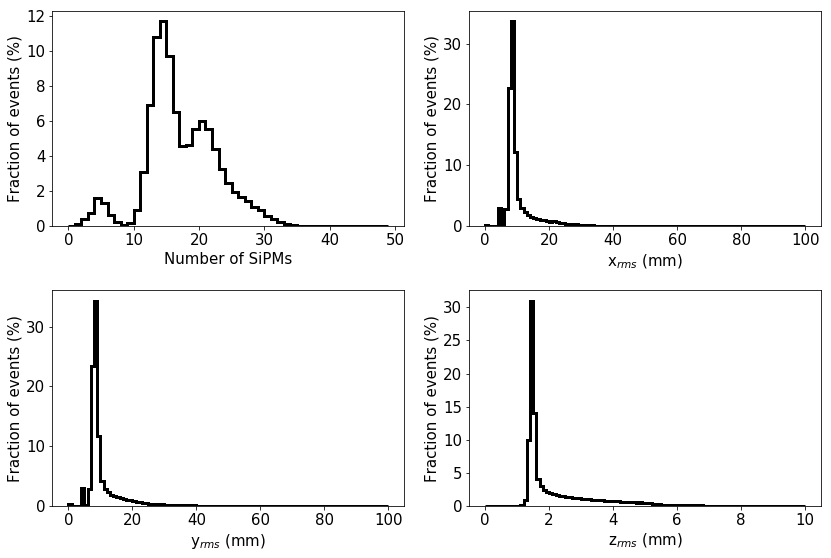

In [19]:
plt.subplot(2, 2, 1)
norm_hist(df.Nsipm, np.arange(0, 50))
plt.xlabel("Number of SiPMs")
plt.ylabel("Fraction of events (%)")

plt.subplot(2, 2, 2)
norm_hist(df.Xrms, np.linspace(0, 100, 101))
plt.xlabel("x$_{rms}$ (mm)")
plt.ylabel("Fraction of events (%)")

plt.subplot(2, 2, 3)
norm_hist(df.Yrms, np.linspace(0, 100, 101))
plt.xlabel("y$_{rms}$ (mm)")
plt.ylabel("Fraction of events (%)")

plt.subplot(2, 2, 4)
norm_hist(df.Zrms, np.linspace(0, 10, 101))
plt.xlabel("z$_{rms}$ (mm)")
plt.ylabel("Fraction of events (%)")

plt.tight_layout()

# Corrected energy distributions

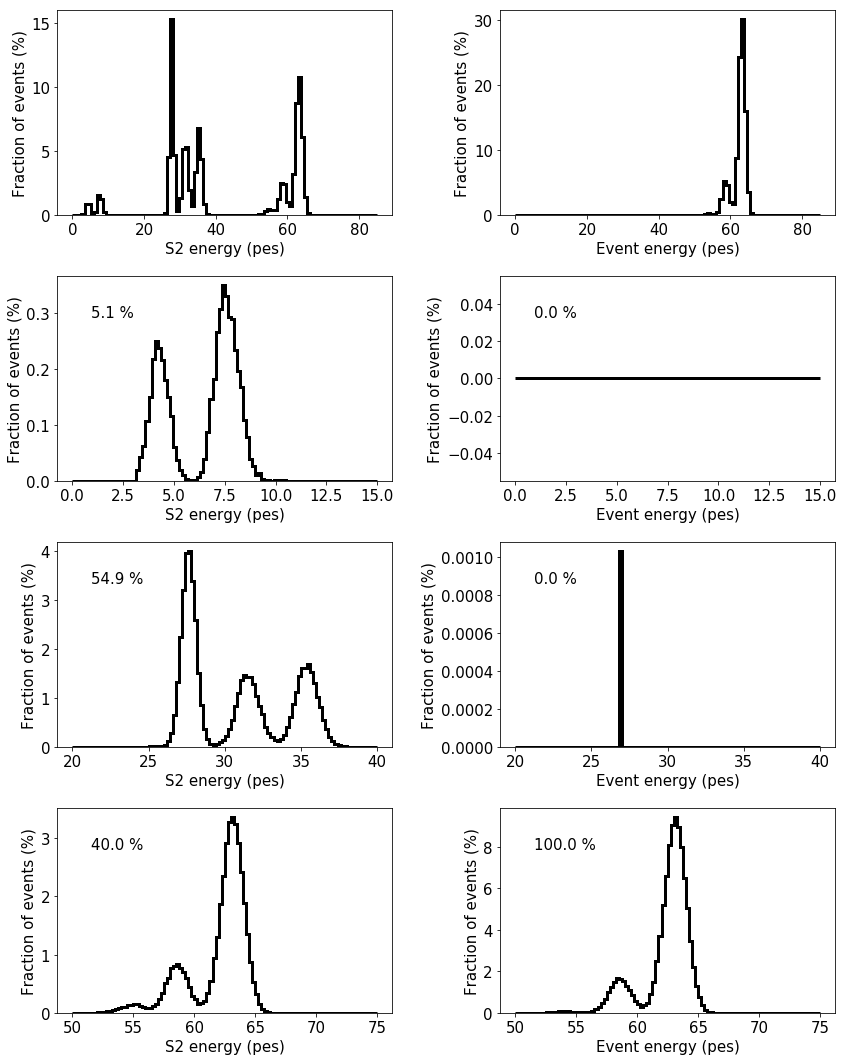

In [23]:
plt.figure(figsize=(12, 15))
evt_energy = df.groupby("event").Ecorr.sum()

plt.subplot(4, 2, 1)
norm_hist(df.Ecorr, np.linspace(0, 85, 101))
plt.xlabel("S2 energy (pes)")
plt.ylabel("Fraction of events (%)")

plt.subplot(4, 2, 2)
norm_hist(evt_energy, np.linspace(0, 85, 101))
plt.xlabel("Event energy (pes)")
plt.ylabel("Fraction of events (%)")

plt.subplot(4, 2, 3)
norm_hist_and_fraction(df.Ecorr, np.linspace(0, 15, 101))
plt.xlabel("S2 energy (pes)")
plt.ylabel("Fraction of events (%)")

plt.subplot(4, 2, 4)
norm_hist_and_fraction(evt_energy, np.linspace(0, 15, 101))
plt.xlabel("Event energy (pes)")
plt.ylabel("Fraction of events (%)")

plt.subplot(4, 2, 5)
norm_hist_and_fraction(df.Ecorr, np.linspace(20, 40, 101))
plt.xlabel("S2 energy (pes)")
plt.ylabel("Fraction of events (%)")

plt.subplot(4, 2, 6)
norm_hist_and_fraction(evt_energy, np.linspace(20, 40, 101))
plt.xlabel("Event energy (pes)")
plt.ylabel("Fraction of events (%)")

plt.subplot(4, 2, 7)
norm_hist_and_fraction(df.Ecorr, np.linspace(50, 75, 101))
plt.xlabel("S2 energy (pes)")
plt.ylabel("Fraction of events (%)")

plt.subplot(4, 2, 8)
norm_hist_and_fraction(evt_energy, np.linspace(50, 75, 101))
plt.xlabel("Event energy (pes)")
plt.ylabel("Fraction of events (%)")

plt.tight_layout()

Text(0, 0.5, 'X-ray 2 energy (keV)')

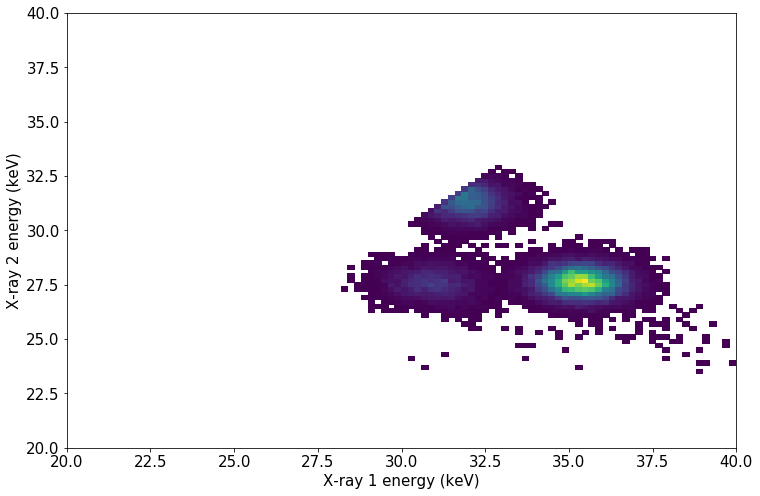

In [25]:
subdf  = df[df.nS2 == 2]
gb     = subdf.groupby("event")
e2, e1 = zip(*[np.sort(g.Ecorr.values) for _, g in gb])
plt.hist2d(e1, e2, (np.linspace(20, 40, 101), np.linspace(20, 40, 101)), cmin=1)
plt.xlabel("X-ray 1 energy (keV)")
plt.ylabel("X-ray 2 energy (keV)")